## Предобработка данных

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Загрузим набор данных

df = pd.read_csv('freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

В предыдущем уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [3]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [4]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Перекодируем переменные типа `object` с помощью числовых значений

In [5]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [6]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [7]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

**NB**: В H2O не рекомендуется использовать one-hot encoding, поскольку данный фреймворк корректно работает с категориальными признаками, тогда как применение one-hot encoding приводит к неэффективности. Тем не менее, используем здесь фиктивные переменные, чтобы в дальнейшем сохранить возможность сравнения результатов построенных моделей.

In [8]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [9]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [10]:
df['SocioCateg'].unique()

array(['CSP50', 'CSP55', 'CSP60', 'CSP48', 'CSP6', 'CSP66', 'CSP1',
       'CSP46', 'CSP21', 'CSP47', 'CSP42', 'CSP37', 'CSP22', 'CSP3',
       'CSP49', 'CSP20', 'CSP2', 'CSP40', 'CSP7', 'CSP26', 'CSP65',
       'CSP41', 'CSP17', 'CSP57', 'CSP56', 'CSP38', 'CSP51', 'CSP59',
       'CSP30', 'CSP44', 'CSP61', 'CSP63', 'CSP45', 'CSP16', 'CSP43',
       'CSP39', 'CSP5', 'CSP32', 'CSP35', 'CSP73', 'CSP62', 'CSP52',
       'CSP27', 'CSP24', 'CSP19', 'CSP70'], dtype=object)

In [11]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [12]:
df['SocioCateg'].unique()

array(['CSP5', 'CSP6', 'CSP4', 'CSP1', 'CSP2', 'CSP3', 'CSP7'],
      dtype=object)

In [13]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [14]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

Теперь, когда большинство переменных типа `object` обработаны, исключим их из набора данных за ненадобностью.

In [15]:
df = df.select_dtypes(exclude=['object'])

Также создадим такую переменную, как квадрат возраста.

In [16]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,3249


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [17]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [18]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [19]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from c:\users\aech\appdata\local\programs\python\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\aech\AppData\Local\Temp\tmpibjprxv0
  JVM stdout: C:\Users\aech\AppData\Local\Temp\tmpibjprxv0\h2o_aech_started_from_python.out
  JVM stderr: C:\Users\aech\AppData\Local\Temp\tmpibjprxv0\h2o_aech_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,"14 days, 3 hours and 6 minutes"
H2O_cluster_name:,H2O_from_python_aech_zhzey3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.973 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


## * Домашнее задание: GLM для прогнозирования наступления страхового случая

In [21]:
# Разбиение датасета на train/val/test
from sklearn.model_selection import train_test_split
x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, y_test_ind, test_size=0.5, random_state=1)

In [22]:
# Преобразование в H2O-Frame

h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

h2o_train_ind['ClaimInd'] = h2o_train_ind['ClaimInd'].asfactor()
h2o_valid_ind['ClaimInd'] = h2o_valid_ind['ClaimInd'].asfactor()
h2o_test_ind['ClaimInd'] = h2o_test_ind['ClaimInd'].asfactor() 

In [24]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_binomial = H2OGeneralizedLinearEstimator(family = "binomial", 
                                             link = "Logit", 
                                             nfolds=5)
glm_binomial.train(y="ClaimInd", 
                   x = h2o_train_ind.names[1:-1], 
                   training_frame = h2o_train_ind, 
                   validation_frame = h2o_valid_ind, 
                   weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [25]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_binomial.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 3.295E-5 )",20,19,3,py_1_sid_b108


In [26]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_binomial.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.48172003,0.11570506,0.47126707,0.5635415,0.43116844,0.61959255,0.3230306
1,auc,0.56707615,0.0064221877,0.57456094,0.5697366,0.5647617,0.5688994,0.5574223
2,aucpr,0.15546022,0.005373766,0.15842918,0.16133197,0.15528125,0.15529308,0.14696567
3,err,0.51827997,0.11570506,0.5287329,0.43645856,0.56883156,0.38040745,0.6769694
4,err_count,3697.0051,838.0687,3706.348,3128.558,4056.657,2715.765,4877.698
5,f0point5,0.17675473,0.010760163,0.1785763,0.17893896,0.17761655,0.18919449,0.15944736
6,f1,0.24078314,0.007805866,0.24641778,0.23840305,0.24712637,0.24373078,0.22823775
7,f2,0.38086638,0.029032657,0.39738506,0.35705915,0.40602225,0.3424413,0.4014242
8,lift_top_group,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,logloss,0.38011712,0.005897612,0.3799755,0.37848663,0.38647556,0.38436237,0.37128553


In [27]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_binomial._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.174604,-1.939603
1,LicAge,-0.000189,-0.030147
2,Gender,0.015184,0.007353
3,MariStat,-0.052343,-0.018717
4,DrivAge,-0.003914,-0.058577
5,HasKmLimit,-0.425867,-0.132326
6,BonusMalus,0.006630,0.099958
7,OutUseNb,0.068515,0.045966
8,RiskArea,0.014767,0.032670
9,VehUsage_Private,-0.157718,-0.074800


In [28]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_binomial.coef_norm()
for x in range(len(glm_binomial.cross_validation_models())):
    pmodels[x] = glm_binomial.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,-1.93960,-1.93945,-1.93768,-1.94809,-1.94473,-1.92959
LicAge,-0.03015,-0.02470,-0.04285,-0.05149,0.00000,-0.02728
Gender,0.00735,0.00603,0.01081,0.00017,0.00861,0.01160
MariStat,-0.01872,-0.02643,-0.01448,-0.01754,-0.01636,-0.01970
DrivAge,-0.05858,-0.09210,-0.05411,-0.02401,-0.08566,-0.07957
HasKmLimit,-0.13233,-0.12567,-0.13714,-0.14711,-0.11704,-0.13527
BonusMalus,0.09996,0.09730,0.10016,0.10453,0.10116,0.09510
OutUseNb,0.04597,0.04209,0.03604,0.05497,0.05158,0.04501
RiskArea,0.03267,0.02845,0.04509,0.03569,0.02262,0.03206
VehUsage_Private,-0.07480,-0.08104,-0.06554,-0.06743,-0.07447,-0.06500


In [29]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

ind_train_pred = glm_binomial.predict(h2o_train_ind).as_data_frame()
ind_valid_pred = glm_binomial.predict(h2o_valid_ind).as_data_frame()
ind_test_pred = glm_binomial.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [30]:
ind_train_pred.head(5)

,predict,p0,p1
0,0,0.877886,0.122114
1,0,0.900390,0.099610
2,1,0.846920,0.153080
3,1,0.836548,0.163452
4,0,0.887372,0.112628


In [31]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [32]:
# Отображение репорта по классификации

def report(true, pred, label='Test'):
    print(label)
    print(classification_report(true, pred))
    print(f'confusion_matrix:\n{confusion_matrix(true, pred)}')
    print('\n'+'*'*55)

In [33]:
# Графики дла анализа результатов классификации

from matplotlib import pyplot as plt
%matplotlib inline

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [34]:
report(y_train_ind, ind_train_pred["predict"], 'train')
report(y_valid_ind, ind_valid_pred["predict"], 'valid')
report(y_test_ind,  ind_test_pred["predict"])

train
              precision    recall  f1-score   support

           0       0.92      0.53      0.68     72973
           1       0.11      0.56      0.18      7635

    accuracy                           0.54     80608
   macro avg       0.52      0.54      0.43     80608
weighted avg       0.84      0.54      0.63     80608

confusion_matrix:
[[38910 34063]
 [ 3395  4240]]

*******************************************************
valid
              precision    recall  f1-score   support

           0       0.92      0.53      0.68     15664
           1       0.11      0.57      0.19      1609

    accuracy                           0.54     17273
   macro avg       0.52      0.55      0.43     17273
weighted avg       0.85      0.54      0.63     17273

confusion_matrix:
[[8374 7290]
 [ 696  913]]

*******************************************************
Test
              precision    recall  f1-score   support

           0       0.92      0.53      0.68     15649
           1

c:\users\aech\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


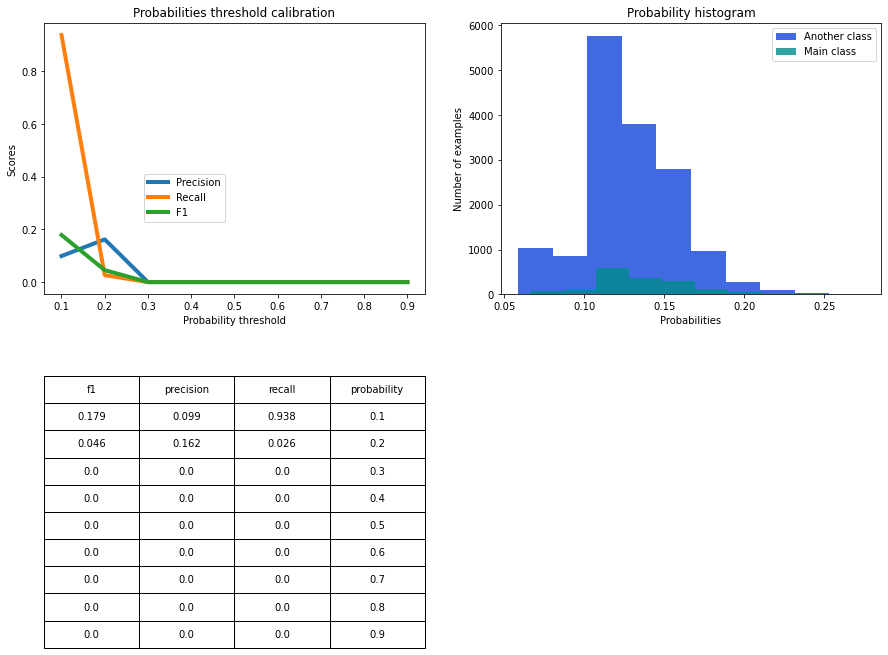

In [35]:
show_proba_calibration_plots(ind_test_pred['p1'], y_test_ind)

Какие проблемы вы здесь видите? Как можно улучшить данный результат?

* Заметна сильная несбалансированность обучающей выборки: 72973 меток 0 класса и 7635 меток 1 класса в обучающей выборке. 
* Очень много ошибок 1 и 2 рода. 
* Очень низкая точность (precision) предсказания меток класса 1, в то время, как эта же оценка для предсказания меток класса 0 достаточно высока.
* По гистограммам плотностей вероятности принадлежности к классам видно, что модель плохо разделяет классы.

1) Попробуем выполнить балансировку выборки с помощью оверсемплинга класса 1  настройкой параметров balance_classes, class_sampling_factors

2) снова обучим модель используя кросс-валидацию на стратифицированых фолдах (fold_assignment = 'Stratified')

* weights_column и balance_classes одновременно использовать нельзя, поэтому Exposure включим в обучающую выборку.

3) попробуем отрегулировать порог принятия решения.

In [293]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_binomial_balanced_1 = H2OGeneralizedLinearEstimator(family = "binomial", 
                                                      link = "Logit", 
                                                      nfolds=5,
                                                      fold_assignment='Stratified',
                                                      balance_classes = True,
                                                      class_sampling_factors=[1., 9.],

glm_binomial_balanced_1.train(y="ClaimInd", 
                            x = h2o_train_ind.names[0:-1], 
                            training_frame = h2o_train_ind,
                            validation_frame = h2o_valid_ind)
                           # weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [295]:
glm_binomial_balanced_1.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7005515,0.022356264,0.738228,0.68541616,0.6829132,0.6943931,0.7018072
1,auc,0.6841583,0.0062964046,0.6817996,0.6870404,0.6882594,0.6895011,0.6741911
2,aucpr,0.16952884,0.0033666003,0.169303,0.17009138,0.17168635,0.17259473,0.1639688
3,err,0.29944846,0.022356264,0.261772,0.31458384,0.3170868,0.3056069,0.29819277
4,err_count,4827.8,366.0392,4225.0,5095.0,5107.0,4960.0,4752.0
5,f0point5,0.19203047,0.00366627,0.1967277,0.18800634,0.19484779,0.1894251,0.19114543
6,f1,0.25244066,0.0034936059,0.25075367,0.2510657,0.25867325,0.25052887,0.25118184
7,f2,0.36883426,0.014788389,0.34568745,0.37777582,0.38468182,0.36982512,0.36620107
8,lift_top_group,2.5604115,0.19127978,2.6063998,2.7993085,2.2884343,2.472994,2.6349206
9,logloss,0.29557252,0.0037163405,0.29597607,0.290465,0.29997018,0.29353377,0.29791757


In [296]:
ind_train_pred_balanced_1 = glm_binomial_balanced_1.predict(h2o_train_ind).as_data_frame()
ind_valid_pred_balanced_1 = glm_binomial_balanced_1.predict(h2o_valid_ind).as_data_frame()
ind_test_pred_balanced_1 = glm_binomial_balanced_1.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [297]:
report(y_train_ind, ind_train_pred_balanced_1["predict"], 'train')
report(y_valid_ind, ind_valid_pred_balanced_1["predict"], 'valid')
report(y_test_ind,  ind_test_pred_balanced_1["predict"])

train
              precision    recall  f1-score   support

           0       0.93      0.74      0.83     72973
           1       0.17      0.49      0.25      7635

    accuracy                           0.72     80608
   macro avg       0.55      0.62      0.54     80608
weighted avg       0.86      0.72      0.77     80608

confusion_matrix:
[[54306 18667]
 [ 3864  3771]]

*******************************************************
valid
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     15664
           1       0.17      0.50      0.25      1609

    accuracy                           0.72     17273
   macro avg       0.55      0.62      0.54     17273
weighted avg       0.86      0.72      0.78     17273

confusion_matrix:
[[11650  4014]
 [  800   809]]

*******************************************************
Test
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     15649
        

c:\users\aech\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


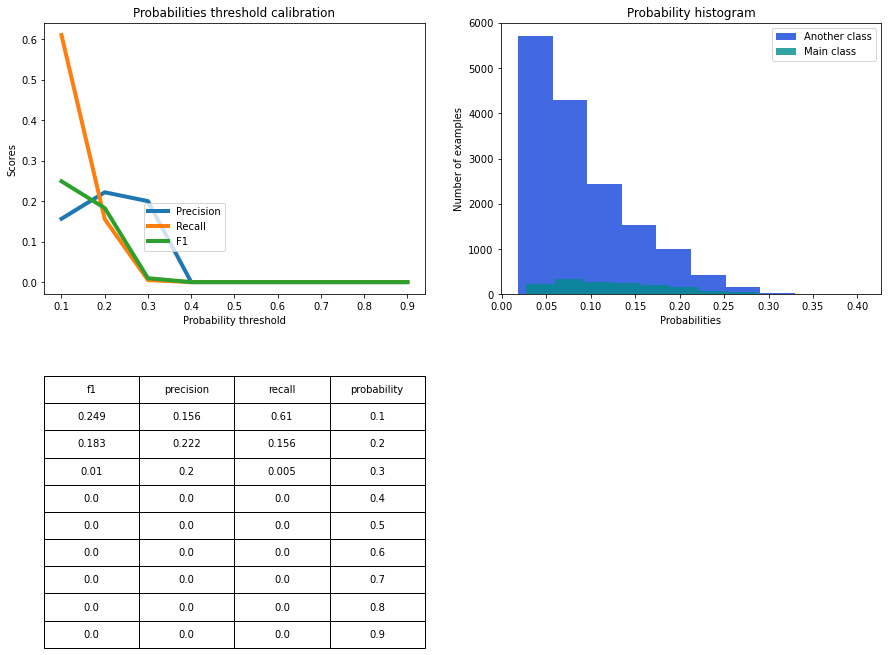

In [298]:
show_proba_calibration_plots(ind_test_pred_balanced_1['p1'], y_test_ind)

#### F1 удалось немного повысить, но все равно результат слабый. К тому же результат чуть-чуть повысился из-за включения в тренировочный набор Exposure, а не из-за балансировки, так как она почему то не сработала
###  "balance_classes"  и "class_sampling_factors" вообще никак не влияли на результат: что с ним, что без них, результат один и тот же. Может я что-то не так делаю, понять не могу.

Попробуем вручную отбалансировать тренировочную выборку и повторить обучение

In [299]:
# калибровка порога классификации

def set_treshold(df_pred, threshold):
    df_pred = df_pred.copy()
    class_1 = df_pred['p1'] > threshold
    df_pred.loc[~class_1,'predict'] = 0
    df_pred.loc[class_1,'predict'] = 1
    return df_pred

In [300]:
# оверсэмплинг для малого класса

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [301]:
df_train = pd.concat([x_train_ind, y_train_ind], axis=1)
df_train_balanced = balance_df_by_target(df_train, 'ClaimInd')
print('before', df_train.shape)
print('after', df_train_balanced.shape)
df_train_balanced['ClaimInd'].value_counts()

before (80608, 22)
after (141688, 22)


0    72973
1    68715
Name: ClaimInd, dtype: int64

In [302]:
h2o_train_ind_balanced_2 = h2o.H2OFrame(df_train_balanced)
h2o_train_ind_balanced_2['ClaimInd'] = h2o_train_ind_balanced_2['ClaimInd'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [309]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_binomial_balanced_2 = H2OGeneralizedLinearEstimator(family = "binomial", 
                                                      link = "Logit", 
                                                      nfolds=5,
                                                      fold_assignment='Stratified')

glm_binomial_balanced_2.train(y="ClaimInd", 
                              x = h2o_train_ind_balanced_2.names[0:-1], 
                              training_frame = h2o_train_ind_balanced_2,
                              validation_frame = h2o_valid_ind)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [310]:
glm_binomial_balanced_2.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.6114047,0.012141104,0.6118435,0.61430734,0.5907394,0.6186707,0.6214625
1,auc,0.68712765,0.0040917774,0.68576413,0.68423986,0.68273234,0.69164014,0.69126177
2,aucpr,0.6407925,0.0048669833,0.6441773,0.636253,0.6351615,0.64617974,0.64219093
3,err,0.3885953,0.012141104,0.3881565,0.38569266,0.40926057,0.38132927,0.37853748
4,err_count,11012.4,366.935,11012.0,10961.0,11623.0,10792.0,10674.0
5,f0point5,0.607479,0.0076389294,0.60874414,0.608037,0.59450185,0.61238897,0.6137229
6,f1,0.6865231,0.0022043034,0.68551517,0.68476605,0.6845605,0.6892779,0.6884959
7,f2,0.78942806,0.0098711755,0.78444445,0.7836568,0.80677557,0.78824675,0.7840166
8,lift_top_group,1.5337433,0.065003216,1.5315017,1.5290576,1.4925388,1.6415306,1.4740877
9,logloss,0.6377566,0.0024310348,0.63870394,0.63933456,0.6403774,0.63491744,0.63544947


In [311]:
ind_train_pred_balanced_2 = glm_binomial_balanced_2.predict(h2o_train_ind_balanced_2).as_data_frame()
ind_valid_pred_balanced_2 = glm_binomial_balanced_2.predict(h2o_valid_ind).as_data_frame()
ind_test_pred_balanced_2 = glm_binomial_balanced_2.predict(h2o_test_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [312]:
report(df_train_balanced['ClaimInd'], ind_train_pred_balanced_2["predict"], 'train')
report(y_valid_ind, ind_valid_pred_balanced_2["predict"], 'valid')
report(y_test_ind,  ind_test_pred_balanced_2["predict"])

train
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     72973
           1       0.65      0.49      0.56     68715

    accuracy                           0.62    141688
   macro avg       0.63      0.62      0.61    141688
weighted avg       0.63      0.62      0.62    141688

confusion_matrix:
[[54782 18191]
 [35171 33544]]

*******************************************************
valid
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     15664
           1       0.17      0.50      0.25      1609

    accuracy                           0.73     17273
   macro avg       0.55      0.62      0.54     17273
weighted avg       0.86      0.73      0.78     17273

confusion_matrix:
[[11754  3910]
 [  811   798]]

*******************************************************
Test
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     15649
        

c:\users\aech\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


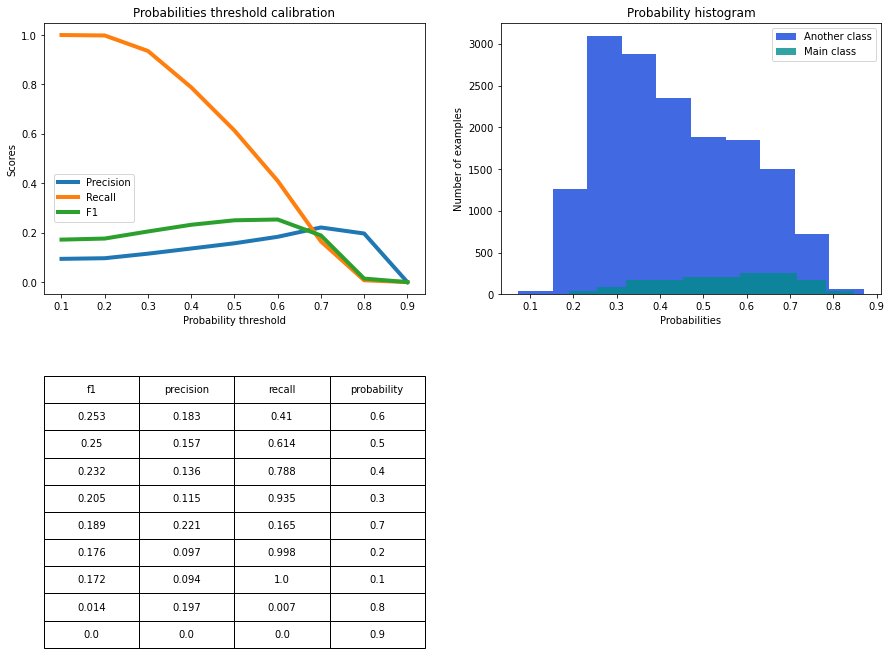

In [313]:
show_proba_calibration_plots(ind_test_pred_balanced_2['p1'], y_test_ind)

In [314]:
THR = 0.58
ind_test_pred_balanced_1_trh = set_treshold(ind_test_pred_balanced_2, THR)

report(y_test_ind,  ind_test_pred_balanced_1_trh["predict"])

Test
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     15649
           1       0.18      0.46      0.26      1625

    accuracy                           0.75     17274
   macro avg       0.55      0.62      0.55     17274
weighted avg       0.86      0.75      0.79     17274

confusion_matrix:
[[12197  3452]
 [  883   742]]

*******************************************************


Ручная балансировка и калибровка порога еще немного высили результат по f1 и accuracy

Существуют еще другие способы избавления от дисбаланса классов, например, удаление наблюдений класса 0, которые находятся "близко" к наблюдениям класса 1. И другие.

К тому же для улучшения результата нужно попробовать Feature Engineering, но на него у меня не хватило времени. Долго разбирался со встроенной балансировкой ("balance_classes" и "class_sampling_factors"), прочитал много документации, но у меня так и не заработало. Надеюсь на Вашу помощь.